In [2]:
# GLOBALS
LOCAL_ROOT = "/Users/varunn/Documents/"
PROJ_PATH = LOCAL_ROOT + "Annotated-Semantic-Relationships-Datasets/"
DATA_PATH = PROJ_PATH + "datasets/"

In [3]:
with open(DATA_PATH+"SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT") as f:
    train_file = f.readlines()

In [5]:
print(type(train_file))
print(len(train_file))

<class 'list'>
32000


In [10]:
train_file[4]

'2\t"The <e1>child</e1> was carefully wrapped and bound into the <e2>cradle</e2> by means of a cord."\n'

In [12]:
to_replace = [("\"", ""), ("\n", ""), ("<", " <"), (">", "> ")]
for line in train_file[:2]:
    print(line)
    print(line.split("\t"))
    sl = line.split("\t")
    if sl[0].isdigit():
            sent = sl[1]
            for rp in to_replace:
                print(rp)
                sent = sent.replace(rp[0], rp[1])
                print(sent)

1	"The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>."

['1', '"The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>."\n']
('"', '')
The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.

('\n', '')
The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.
('<', ' <')
The system as described above has its greatest application in an arrayed  <e1>configuration </e1> of antenna  <e2>elements </e2>.
('>', '> ')
The system as described above has its greatest application in an arrayed  <e1> configuration </e1>  of antenna  <e2> elements </e2> .
Component-Whole(e2,e1)

['Component-Whole(e2,e1)\n']


In [13]:
def prepare_dataset(raw):
    sentences, relations = [], []
    to_replace = [("\"", ""), ("\n", ""), ("<", " <"), (">", "> ")]
    last_was_sentence = False
    for line in raw:
        sl = line.split("\t")
        if last_was_sentence:
            relations.append(sl[0].split("(")[0].replace("\n", ""))
            last_was_sentence = False
        if sl[0].isdigit():
            sent = sl[1]
            for rp in to_replace:
                sent = sent.replace(rp[0], rp[1])
            sentences.append(sent)
            last_was_sentence = True
    print("Found {} sentences".format(len(sentences)))
    return sentences, relations

In [14]:
sentences, relations = prepare_dataset(train_file)

Found 8000 sentences


In [15]:
print(len(sentences))
print(len(relations))

8000
8000


In [19]:
for i, value in enumerate(sentences[:10]):
    print(i)
    print(value, "******", relations[i])
    print("\n")

0
The system as described above has its greatest application in an arrayed  <e1> configuration </e1>  of antenna  <e2> elements </e2> . ****** Component-Whole


1
The  <e1> child </e1>  was carefully wrapped and bound into the  <e2> cradle </e2>  by means of a cord. ****** Other


2
The  <e1> author </e1>  of a keygen uses a  <e2> disassembler </e2>  to look at the raw assembly code. ****** Instrument-Agency


3
A misty  <e1> ridge </e1>  uprises from the  <e2> surge </e2> . ****** Other


4
The  <e1> student </e1>   <e2> association </e2>  is the voice of the undergraduate student population of the State University of New York at Buffalo. ****** Member-Collection


5
This is the sprawling  <e1> complex </e1>  that is Peru's largest  <e2> producer </e2>  of silver. ****** Other


6
The current view is that the chronic  <e1> inflammation </e1>  in the distal part of the stomach caused by Helicobacter pylori  <e2> infection </e2>  results in an increased acid production from the non-infe

In [21]:
n_relations = len(set(relations))
print("Found {} relations\n".format(n_relations))
print("Relations:\n{}".format(list(set(relations))))

Found 10 relations

Relations:
['Entity-Origin', 'Member-Collection', 'Other', 'Content-Container', 'Cause-Effect', 'Message-Topic', 'Entity-Destination', 'Product-Producer', 'Instrument-Agency', 'Component-Whole']


### Model

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from keras.models import Model, Input
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate, InputSpec
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import regex as re
import pickle
import numpy as np

from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K

class KerasTextClassifier(BaseEstimator, TransformerMixin):
    '''Wrapper class for keras text classification models that takes raw text as input.'''
    
    def __init__(self, max_words=30000, input_length=50, emb_dim=50, n_classes=10):
        self.max_words = max_words
        self.input_length = input_length
        self.emb_dim = emb_dim
        self.n_classes = n_classes
        self.return_attention = True
        self.model = self._get_model()
        self.encoder = LabelEncoder()
        self.tokenizer = Tokenizer(num_words=self.max_words+1, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token="UNK")
    
    def _get_model(self):
        d = 0.5
        rd = 0.5
        rnn_units = 128
        input_text = Input((self.input_length,))
        text_embedding = Embedding(input_dim=self.max_words + 2, output_dim=self.emb_dim,
                                   input_length=self.input_length, mask_zero=True)(input_text)
        text_embedding = SpatialDropout1D(0.5)(text_embedding)
        bilstm = Bidirectional(LSTM(units=rnn_units, return_sequences=True, dropout=d,
                                    recurrent_dropout=rd))(text_embedding)
        x, attn = AttentionWeightedAverage(return_attention=True)(bilstm)
        x = Dropout(0.5)(x)
        out = Dense(units=self.n_classes, activation="softmax")(x)
        model = Model(input_text, out)
        return model
    
    def _get_attention_map(self, texts):
        att_model_output = self.model.layers[0:-2]
        att_model = Model(att_model_output[0].input, att_model_output[-1].output)
        att_model.compile(optimizer=RMSprop(),
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])
        return att_model.predict(self._get_sequences(texts))[1]
    
    def _get_sequences(self, texts):
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self.input_length,
                             value=0, padding='post', truncating='post')
    
    def _labels(self, labels):
        return self.encoder.transform(labels)
    
    def fit(self, X, y, X_val=None, y_val=None, lr=0.001, resume=False,
            epochs=10, batch_size=32):
        '''
        Fit the vocabulary and the model.
        
        :params:
        X: list of texts
        y: labels
        X_val: list of texts for validation
        y_val: labels for validation.
        '''
        self.model.compile(optimizer=RMSprop(clipnorm=10., lr=lr),
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])
        
        if not resume:
            self.tokenizer.fit_on_texts(X)
            self.encoder.fit(y)
            self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.max_words}
            self.tokenizer.word_index[self.tokenizer.oov_token] = self.max_words + 1
        else:
            print("Resuming training...")
        seqs = self._get_sequences(X)
        categorical_y = self._labels(y)
        print("Fit text model with {} classes".format(len(self.encoder.classes_)))
        if X_val:
            val_seqs = self._get_sequences(X_val)
            categorical_y_val = self._labels(y_val)
            self.model.fit(seqs, categorical_y, batch_size=batch_size,
                           epochs=epochs, validation_data=(val_seqs, categorical_y_val))
        else:
            self.model.fit(seqs, categorical_y, batch_size=batch_size,
                           epochs=epochs, validation_split=0.1)
    
    def predict_proba(self, X, y=None):
        return self.model.predict(self._get_sequences(X))
    
    def predict(self, X, y=None):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def save(self, path="model"):                               
        self.model.save_weights('{}_weights.h5'.format(path))          
        with open("{}_index.pkl".format(path), "wb") as f:                      
            pickle.dump([self.encoder, self.tokenizer, self.max_words,
                         self.emb_dim, self.input_length, self.n_classes], f)         
            
    def load(self, path="model"):                                                              
        with open("{}_index.pkl".format(path), "rb") as f:
            self.encoder, self.tokenizer, self.max_words, self.emb_dim, self.input_length, self.n_classes = pickle.load(f)                                                                     
        self.model = self._get_model()                                           
        self.model.load_weights('{}_weights.h5'.format(path))
        
        
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average attention mechanism from:
        Zhou, Peng, Wei Shi, Jun Tian, Zhenyu Qi, Bingchen Li, Hongwei Hao and Bo Xu.
        “Attention-Based Bidirectional Long Short-Term Memory Networks for Relation Classification.”
        ACL (2016). http://www.aclweb.org/anthology/P16-2034
    How to use:
    see: [BLOGPOST]
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.w = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_w'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.w]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, h, mask=None):
        h_shape = K.shape(h)
        d_w, T = h_shape[0], h_shape[1]
        
        logits = K.dot(h, self.w)  # w^T h
        logits = K.reshape(logits, (d_w, T))
        alpha = K.exp(logits - K.max(logits, axis=-1, keepdims=True))  # exp
        
        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            alpha = alpha * mask
        alpha = alpha / K.sum(alpha, axis=1, keepdims=True) # softmax
        r = K.sum(h * K.expand_dims(alpha), axis=1)  # r = h*alpha^T
        h_star = K.tanh(r)  # h^* = tanh(r)
        if self.return_attention:
            return [h_star, alpha]
        return h_star

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
classifier = KerasTextClassifier()

In [26]:
classifier.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1500100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           183296    
_________________________________________________________________
attention_weighted_average_1 [(None, 256), (None, 50)] 256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total para

In [28]:
classifier.model.layers[0:-2]

In [29]:
att_model_output = classifier.model.layers[0:-2]

In [31]:
att_model_output[0].input

<tf.Tensor 'input_1:0' shape=(?, 50) dtype=float32>

In [32]:
att_model_output[-1].output

[<tf.Tensor 'attention_weighted_average_1/Tanh:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'attention_weighted_average_1/truediv:0' shape=(?, 50) dtype=float32>]

In [33]:
att_model = Model(att_model_output[0].input, att_model_output[-1].output)

In [35]:
att_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1500100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           183296    
_________________________________________________________________
attention_weighted_average_1 [(None, 256), (None, 50)] 256       
Total params: 1,683,652
Trainable params: 1,683,652
Non-trainable params: 0
_________________________________________________________________


In [36]:
import numpy as np
from sklearn.model_selection import train_test_split

In [37]:
kclf = KerasTextClassifier(input_length=50, n_classes=n_relations,
                           max_words=15000)

In [39]:
tr_sent, te_sent, tr_rel, te_rel = train_test_split(sentences, relations,
                                                    test_size=0.1)

In [40]:
kclf.fit(X=tr_sent, y=tr_rel, X_val=te_sent, y_val=te_rel,
         batch_size=10, lr=0.001, epochs=20)

Fit text model with 10 classes
Train on 7200 samples, validate on 800 samples
Epoch 1/20
7200/7200 [==============================] - 53s 7ms/step - loss: 2.1610 - acc: 0.2138 - val_loss: 1.9553 - val_acc: 0.3238
Epoch 2/20
7200/7200 [==============================] - 1497s 208ms/step - loss: 1.8698 - acc: 0.3325 - val_loss: 1.6720 - val_acc: 0.4038
Epoch 3/20
7200/7200 [==============================] - 47s 6ms/step - loss: 1.6707 - acc: 0.3947 - val_loss: 1.4884 - val_acc: 0.4700
Epoch 4/20
7200/7200 [==============================] - 48s 7ms/step - loss: 1.5326 - acc: 0.4411 - val_loss: 1.3938 - val_acc: 0.5113
Epoch 5/20
7200/7200 [==============================] - 47s 7ms/step - loss: 1.4139 - acc: 0.4839 - val_loss: 1.3201 - val_acc: 0.5400
Epoch 6/20
7200/7200 [==============================] - 49s 7ms/step - loss: 1.3101 - acc: 0.5332 - val_loss: 1.2806 - val_acc: 0.5650
Epoch 7/20
7200/7200 [==============================] - 49s 7ms/step - loss: 1.2242 - acc: 0.5742 - val_loss

### Investigate Attention

In [41]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [42]:
y_pred = kclf.predict(te_sent)
y_attn = kclf._get_attention_map(te_sent)

In [44]:
print(y_pred.shape)
print(y_attn.shape)

(800,)
(800, 50)


In [49]:
i = 354
activation_map = np.expand_dims(y_attn[i][:len(te_sent[i].split())],
                                axis=1)

In [56]:
print(activation_map.shape)
print(len(te_sent[i].split()))
print(y_attn[i])
print(activation_map)

(27, 1)
27
[0.01558651 0.01449839 0.01680612 0.01850547 0.01820385 0.01465497
 0.01759021 0.02704462 0.02673839 0.04463168 0.05781578 0.09438042
 0.13398896 0.21263286 0.06846104 0.04793824 0.02544727 0.01812222
 0.0131333  0.01272279 0.010885   0.01253266 0.01260024 0.01428044
 0.01428257 0.01866479 0.01785124 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[[0.01558651]
 [0.01449839]
 [0.01680612]
 [0.01850547]
 [0.01820385]
 [0.01465497]
 [0.01759021]
 [0.02704462]
 [0.02673839]
 [0.04463168]
 [0.05781578]
 [0.09438042]
 [0.13398896]
 [0.21263286]
 [0.06846104]
 [0.04793824]
 [0.02544727]
 [0.01812222]
 [0.0131333 ]
 [0.01272279]
 [0.010885  ]
 [0.01253266]
 [0.01260024]
 [0.01428044]
 [0.01428257]
 [0.01866479]
 [0.01785124]]


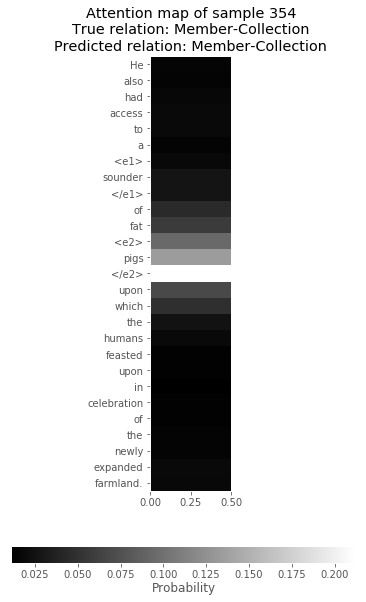

In [57]:
f = plt.figure(figsize=(8, 8))
ax = f.add_subplot(1, 1, 1)

img = ax.imshow(activation_map, interpolation='none', cmap='gray')

plt.xlim([0,0.5])
ax.set_aspect(0.1)
ax.set_yticks(range(len(te_sent[i].split())))
ax.set_yticklabels(te_sent[i].split());
ax.grid()
plt.title("Attention map of sample {}\nTrue relation: {}\nPredicted relation: {}"
          .format(i, te_rel[i], kclf.encoder.classes_[y_pred[i]]));

# add colorbar
cbaxes = f.add_axes([0.2, 0, 0.6, 0.03]);
cbar = f.colorbar(img, cax=cbaxes, orientation='horizontal');
cbar.ax.set_xlabel('Probability', labelpad=2);

### Evaluation

In [58]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [59]:
y_test_pred = kclf.predict(te_sent)

In [60]:
label_idx_to_use = [i for i, c in enumerate(list(kclf.encoder.classes_))
                    if  c !="Other"]
label_to_use = list(kclf.encoder.classes_)
label_to_use.remove("Other")

In [62]:
label_idx_to_use, label_to_use

([0, 1, 2, 3, 4, 5, 6, 7, 9],
 ['Cause-Effect',
  'Component-Whole',
  'Content-Container',
  'Entity-Destination',
  'Entity-Origin',
  'Instrument-Agency',
  'Member-Collection',
  'Message-Topic',
  'Product-Producer'])

In [63]:
print("F1-Score: {:.1%}"
      .format(f1_score(kclf.encoder.transform(te_rel), y_test_pred,
                       average="macro", labels=label_idx_to_use)))

F1-Score: 71.0%


In [64]:
print(classification_report(kclf.encoder.transform(te_rel), y_test_pred,
                            target_names=label_to_use,
                            labels=label_idx_to_use))

                    precision    recall  f1-score   support

      Cause-Effect       0.83      0.83      0.83       100
   Component-Whole       0.60      0.68      0.64        90
 Content-Container       0.72      0.84      0.77        43
Entity-Destination       0.86      0.73      0.79        88
     Entity-Origin       0.78      0.78      0.78        80
 Instrument-Agency       0.54      0.60      0.57        50
 Member-Collection       0.77      0.87      0.82        75
     Message-Topic       0.56      0.70      0.62        57
  Product-Producer       0.55      0.61      0.58        69

         micro avg       0.70      0.74      0.72       652
         macro avg       0.69      0.74      0.71       652
      weighted avg       0.71      0.74      0.72       652

